# data prepro

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms.functional import rotate, InterpolationMode, to_tensor
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

mnist_train = torchvision.datasets.MNIST(root='./data', train=True,  download=True)
mnist_test  = torchvision.datasets.MNIST(root='./data', train=False, download=True)

train_idx = np.random.choice(len(mnist_train), size=5000, replace=False)
test_idx  = np.random.choice(len(mnist_test),  size=5000, replace=False)

class RotatedDigits(Dataset):
    def __init__(self, base_ds, idxs):
        self.base   = base_ds
        self.idxs   = idxs
        self.angles = np.random.uniform(-45, 45, size=len(idxs)).astype(np.float32)
    def __len__(self):
        return len(self.idxs)
    def __getitem__(self, i):
        img, _ = self.base[self.idxs[i]]
        angle   = float(self.angles[i])
        img_r = rotate(img, angle,
                       interpolation=InterpolationMode.BILINEAR,
                       fill=0)
        x = to_tensor(img_r) 
        return x, torch.tensor(angle)

# build datasets
train_ds = RotatedDigits(mnist_train, train_idx)
test_ds  = RotatedDigits(mnist_test,  test_idx)

batch_size = 128
train_loader = DataLoader(train_ds,  batch_size=batch_size, shuffle=True,  drop_last=True)
val_loader   = DataLoader(test_ds,   batch_size=batch_size, shuffle=False, drop_last=False)
test_loader  = val_loader  

print(f"▶ Train: {len(train_ds)} samples\n▶ Val/Test: {len(test_ds)} samples")


▶ Train: 5000 samples
▶ Val/Test: 5000 samples


# matlab ver

✔ Best at epoch 1: Val RMSE=17.2304
✔ Best at epoch 2: Val RMSE=15.5998
✔ Best at epoch 2: Val RMSE=15.5998
✔ Best at epoch 3: Val RMSE=14.7249
✔ Best at epoch 3: Val RMSE=14.7249
✔ Best at epoch 4: Val RMSE=12.0899
✔ Best at epoch 4: Val RMSE=12.0899
✔ Best at epoch 6: Val RMSE=11.6289
✔ Best at epoch 6: Val RMSE=11.6289
✔ Best at epoch 9: Val RMSE=11.2881
✔ Best at epoch 9: Val RMSE=11.2881
✔ Best at epoch 16: Val RMSE=11.0203
✔ Best at epoch 16: Val RMSE=11.0203
✔ Best at epoch 21: Val RMSE=10.8609
✔ Best at epoch 21: Val RMSE=10.8609
✔ Best at epoch 22: Val RMSE=10.7892
✔ Best at epoch 22: Val RMSE=10.7892
🏆 Best validation RMSE=10.7892 at epoch 22
🏆 Best validation RMSE=10.7892 at epoch 22


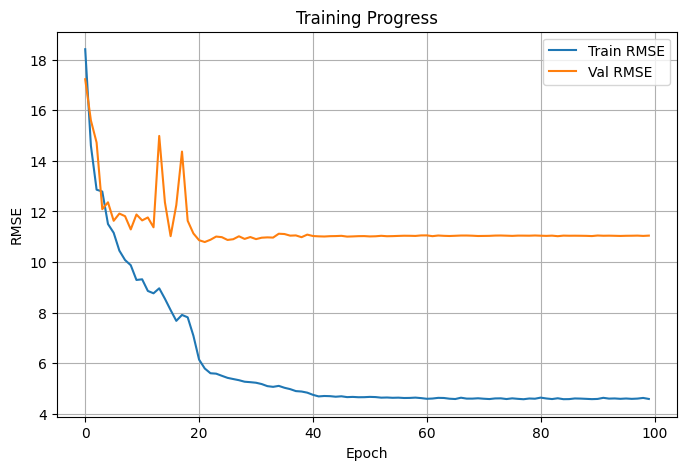

In [127]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device('mps' if torch.cuda.is_available() else 'cpu')

class EnhancedCNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,   8, 3, padding=1),  nn.BatchNorm2d(8),  nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(8,  16, 3, padding=1),  nn.BatchNorm2d(16), nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, 3, padding=1),  nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),  nn.BatchNorm2d(32), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

model = EnhancedCNNRegressor().to(device)


criterion = nn.MSELoss()                 
def rmse(total_loss, n):                
    return math.sqrt(total_loss / n)

optimizer = optim.SGD(model.parameters(),
                      lr=1e-3,
                      momentum=0.9)      
scheduler = optim.lr_scheduler.StepLR(optimizer,
                                      step_size=20,   
                                      gamma=0.1)      

num_epochs = 100
train_rmse_history = []
val_rmse_history   = []
best_val_rmse = float('inf')
best_epoch    = -1

for epoch in range(1, num_epochs + 1):
    model.train()
    total_train_mse = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        total_train_mse += loss.item() * xb.size(0)

    model.eval()
    total_val_mse = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            total_val_mse += criterion(model(xb), yb).item() * xb.size(0)

    train_rmse = rmse(total_train_mse, len(train_loader.dataset))
    val_rmse   = rmse(total_val_mse,   len(val_loader.dataset))
    train_rmse_history.append(train_rmse)
    val_rmse_history.append(val_rmse)

    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_epoch    = epoch
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"✔ Best at epoch {epoch}: Val RMSE={best_val_rmse:.4f}")

    scheduler.step()

print(f"🏆 Best validation RMSE={best_val_rmse:.4f} at epoch {best_epoch}")

plt.figure(figsize=(8,5))
plt.plot(train_rmse_history, label='Train RMSE')
plt.plot(val_rmse_history,   label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()


# 64 channels

In [ ]:
import torch, math
import torch.nn as nn, torch.optim as optim

device = torch.device('mps' if torch.cuda.is_available() else 'cpu')

class EnhancedCNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,   8, 3, padding=1), nn.BatchNorm2d(8),  nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(8,  16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            # Added layers 
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

model     = EnhancedCNNRegressor().to(device)
criterion = nn.L1Loss()  # MAE loss
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

best_val_mae = float('inf')
best_epoch    = -1

for epoch in range(1, 101):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    train_mae = running_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item() * xb.size(0)
    val_mae = val_loss / len(val_loader.dataset)

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_epoch    = epoch
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"✔ Best at epoch {epoch}: Val MAE={best_val_mae:.4f}")

    scheduler.step()
    print(f"Epoch {epoch:2d} | Train MAE: {train_mae:.4f} | Val MAE: {val_mae:.4f} | LR: {scheduler.get_last_lr()[0]:.1e}")

print(f"🏆 Best validation MAE={best_val_mae:.4f} at epoch {best_epoch}")


✔ Best at epoch 1: Val MAE=14.6943
Epoch  1 | Train MAE: 18.7826 | Val MAE: 14.6943 | LR: 1.0e-03
✔ Best at epoch 2: Val MAE=11.9773
Epoch  2 | Train MAE: 11.1853 | Val MAE: 11.9773 | LR: 1.0e-03
✔ Best at epoch 2: Val MAE=11.9773
Epoch  2 | Train MAE: 11.1853 | Val MAE: 11.9773 | LR: 1.0e-03
✔ Best at epoch 3: Val MAE=10.2702
Epoch  3 | Train MAE: 9.7520 | Val MAE: 10.2702 | LR: 1.0e-03
✔ Best at epoch 3: Val MAE=10.2702
Epoch  3 | Train MAE: 9.7520 | Val MAE: 10.2702 | LR: 1.0e-03
✔ Best at epoch 4: Val MAE=10.1009
Epoch  4 | Train MAE: 9.1227 | Val MAE: 10.1009 | LR: 1.0e-03
✔ Best at epoch 4: Val MAE=10.1009
Epoch  4 | Train MAE: 9.1227 | Val MAE: 10.1009 | LR: 1.0e-03
Epoch  5 | Train MAE: 8.1708 | Val MAE: 13.3779 | LR: 1.0e-03
Epoch  5 | Train MAE: 8.1708 | Val MAE: 13.3779 | LR: 1.0e-03
✔ Best at epoch 6: Val MAE=10.0841
Epoch  6 | Train MAE: 7.9238 | Val MAE: 10.0841 | LR: 1.0e-03
✔ Best at epoch 6: Val MAE=10.0841
Epoch  6 | Train MAE: 7.9238 | Val MAE: 10.0841 | LR: 1.0e-03


# 32 channels (best)

In [ ]:
import torch, math
import torch.nn as nn, torch.optim as optim

device = torch.device('mps' if torch.cuda.is_available() else 'cpu')

class EnhancedCNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,   8, 3, padding=1), nn.BatchNorm2d(8),  nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(8,  16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            # Added layers 
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

model     = EnhancedCNNRegressor().to(device)
criterion = nn.L1Loss() 
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

best_val_mae = float('inf')
best_epoch    = -1

for epoch in range(1, 101):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    train_mae = running_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item() * xb.size(0)
    val_mae = val_loss / len(val_loader.dataset)

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_epoch    = epoch
        torch.save(model.state_dict(), 'best_model_try.pt')
        print(f"✔ Best at epoch {epoch}: Val MAE={best_val_mae:.4f}")

    scheduler.step()
    print(f"Epoch {epoch:2d} | Train MAE: {train_mae:.4f} | Val MAE: {val_mae:.4f} | LR: {scheduler.get_last_lr()[0]:.1e}")

print(f"🏆 Best validation MAE={best_val_mae:.4f} at epoch {best_epoch}")


✔ Best at epoch 1: Val MAE=18.6088
Epoch  1 | Train MAE: 20.1964 | Val MAE: 18.6088 | LR: 1.0e-03
✔ Best at epoch 2: Val MAE=15.2850
Epoch  2 | Train MAE: 12.6195 | Val MAE: 15.2850 | LR: 1.0e-03
✔ Best at epoch 2: Val MAE=15.2850
Epoch  2 | Train MAE: 12.6195 | Val MAE: 15.2850 | LR: 1.0e-03
✔ Best at epoch 3: Val MAE=10.8933
Epoch  3 | Train MAE: 10.4022 | Val MAE: 10.8933 | LR: 1.0e-03
✔ Best at epoch 3: Val MAE=10.8933
Epoch  3 | Train MAE: 10.4022 | Val MAE: 10.8933 | LR: 1.0e-03
✔ Best at epoch 4: Val MAE=9.8353
Epoch  4 | Train MAE: 9.4871 | Val MAE: 9.8353 | LR: 1.0e-03
✔ Best at epoch 4: Val MAE=9.8353
Epoch  4 | Train MAE: 9.4871 | Val MAE: 9.8353 | LR: 1.0e-03
Epoch  5 | Train MAE: 8.9113 | Val MAE: 12.6843 | LR: 1.0e-03
Epoch  5 | Train MAE: 8.9113 | Val MAE: 12.6843 | LR: 1.0e-03
✔ Best at epoch 6: Val MAE=9.0813
Epoch  6 | Train MAE: 8.1875 | Val MAE: 9.0813 | LR: 1.0e-03
✔ Best at epoch 6: Val MAE=9.0813
Epoch  6 | Train MAE: 8.1875 | Val MAE: 9.0813 | LR: 1.0e-03
✔ Best

In [130]:
import torch, math
import torch.nn as nn, torch.optim as optim

device = torch.device('mps' if torch.cuda.is_available() else 'cpu')

class EnhancedCNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,   8, 3, padding=1), nn.BatchNorm2d(8),  nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(8,  16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            # Added layers 
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

model     = EnhancedCNNRegressor().to(device)
criterion = nn.L1Loss() 
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

best_val_mae = float('inf')
best_epoch    = -1

for epoch in range(1, 101):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    train_mae = running_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item() * xb.size(0)
    val_mae = val_loss / len(val_loader.dataset)

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_epoch    = epoch
        torch.save(model.state_dict(), 'best_model_try.pt')
        print(f"✔ Best at epoch {epoch}: Val MAE={best_val_mae:.4f}")

    scheduler.step()
    print(f"Epoch {epoch:2d} | Train MAE: {train_mae:.4f} | Val MAE: {val_mae:.4f} | LR: {scheduler.get_last_lr()[0]:.1e}")

print(f"🏆 Best validation MAE={best_val_mae:.4f} at epoch {best_epoch}")


✔ Best at epoch 1: Val MAE=14.2107
Epoch  1 | Train MAE: 19.4835 | Val MAE: 14.2107 | LR: 1.0e-03
Epoch  2 | Train MAE: 11.8311 | Val MAE: 19.8333 | LR: 1.0e-03
Epoch  2 | Train MAE: 11.8311 | Val MAE: 19.8333 | LR: 1.0e-03
✔ Best at epoch 3: Val MAE=10.0337
Epoch  3 | Train MAE: 10.2687 | Val MAE: 10.0337 | LR: 1.0e-03
✔ Best at epoch 3: Val MAE=10.0337
Epoch  3 | Train MAE: 10.2687 | Val MAE: 10.0337 | LR: 1.0e-03
Epoch  4 | Train MAE: 9.5650 | Val MAE: 17.7240 | LR: 1.0e-03
Epoch  4 | Train MAE: 9.5650 | Val MAE: 17.7240 | LR: 1.0e-03
Epoch  5 | Train MAE: 9.0575 | Val MAE: 11.5314 | LR: 1.0e-03
Epoch  5 | Train MAE: 9.0575 | Val MAE: 11.5314 | LR: 1.0e-03
Epoch  6 | Train MAE: 8.2916 | Val MAE: 10.4235 | LR: 1.0e-03
Epoch  6 | Train MAE: 8.2916 | Val MAE: 10.4235 | LR: 1.0e-03
✔ Best at epoch 7: Val MAE=8.8632
Epoch  7 | Train MAE: 8.2795 | Val MAE: 8.8632 | LR: 1.0e-03
✔ Best at epoch 7: Val MAE=8.8632
Epoch  7 | Train MAE: 8.2795 | Val MAE: 8.8632 | LR: 1.0e-03
✔ Best at epoch 8:

# avg pooling

In [ ]:
import torch, math
import torch.nn as nn, torch.optim as optim

device = torch.device('mps' if torch.cuda.is_available() else 'cpu')

class EnhancedCNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # Initial conv/pool blocks
            nn.Conv2d(1,   8, 3, padding=1), nn.BatchNorm2d(8),  nn.ReLU(),
            nn.AvgPool2d(2,2),
            nn.Conv2d(8,  16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.AvgPool2d(2,2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            # Added layers 
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

model     = EnhancedCNNRegressor().to(device)
criterion = nn.L1Loss()  
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

best_val_mae = float('inf')
best_epoch    = -1

for epoch in range(1, 101):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    train_mae = running_loss / len(train_loader.dataset)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item() * xb.size(0)
    val_mae = val_loss / len(val_loader.dataset)

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_epoch    = epoch
        torch.save(model.state_dict(), 'best_model_try_avg.pt')
        print(f"✔ Best at epoch {epoch}: Val MAE={best_val_mae:.4f}")

    scheduler.step()
    print(f"Epoch {epoch:2d} | Train MAE: {train_mae:.4f} | Val MAE: {val_mae:.4f} | LR: {scheduler.get_last_lr()[0]:.1e}")

print(f"🏆 Best validation MAE={best_val_mae:.4f} at epoch {best_epoch}")


✔ Best at epoch 1: Val MAE=17.5893
Epoch  1 | Train MAE: 19.0855 | Val MAE: 17.5893 | LR: 1.0e-03
✔ Best at epoch 2: Val MAE=12.2995
Epoch  2 | Train MAE: 12.1217 | Val MAE: 12.2995 | LR: 1.0e-03
✔ Best at epoch 2: Val MAE=12.2995
Epoch  2 | Train MAE: 12.1217 | Val MAE: 12.2995 | LR: 1.0e-03
✔ Best at epoch 3: Val MAE=11.9523
Epoch  3 | Train MAE: 10.4094 | Val MAE: 11.9523 | LR: 1.0e-03
✔ Best at epoch 3: Val MAE=11.9523
Epoch  3 | Train MAE: 10.4094 | Val MAE: 11.9523 | LR: 1.0e-03
✔ Best at epoch 4: Val MAE=9.7935
Epoch  4 | Train MAE: 9.3273 | Val MAE: 9.7935 | LR: 1.0e-03
✔ Best at epoch 4: Val MAE=9.7935
Epoch  4 | Train MAE: 9.3273 | Val MAE: 9.7935 | LR: 1.0e-03
Epoch  5 | Train MAE: 8.7523 | Val MAE: 10.1217 | LR: 1.0e-03
Epoch  5 | Train MAE: 8.7523 | Val MAE: 10.1217 | LR: 1.0e-03
✔ Best at epoch 6: Val MAE=9.0109
Epoch  6 | Train MAE: 8.3993 | Val MAE: 9.0109 | LR: 1.0e-03
✔ Best at epoch 6: Val MAE=9.0109
Epoch  6 | Train MAE: 8.3993 | Val MAE: 9.0109 | LR: 1.0e-03
✔ Best

# show

Sampled MAE over 20 images: 6.9243°


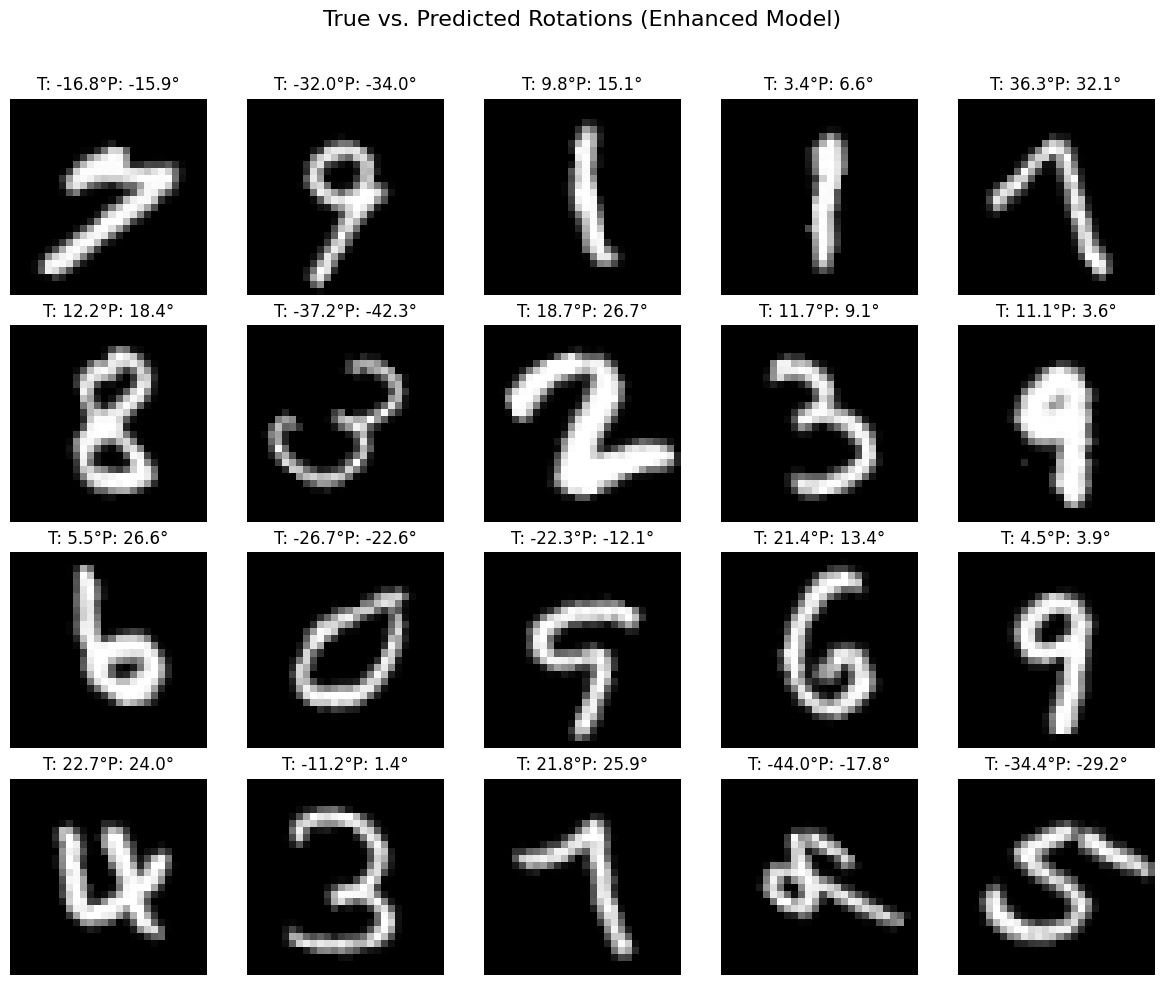

In [ ]:
import torch, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

model = EnhancedCNNRegressor().to(device)
model.load_state_dict(torch.load('best_model.pt', map_location=device))
model.eval()

dataset = val_loader.dataset  # test data
idxs    = np.random.choice(len(dataset), 20, replace=False)

imgs, trues, preds = [], [], []
with torch.no_grad():
    for i in idxs:
        x, y_true = dataset[i]
        y_pred    = model(x.unsqueeze(0).to(device)).item()
        imgs.append(x.squeeze(0).cpu().numpy())
        trues.append(y_true)
        preds.append(y_pred)

sampled_mae = mean_absolute_error(trues, preds)
print(f"Sampled MAE over 20 images: {sampled_mae:.4f}°")

fig, axes = plt.subplots(4, 5, figsize=(12,10))
for ax, im, t, p in zip(axes.flatten(), imgs, trues, preds):
    ax.imshow(im, cmap='gray')
    ax.set_title(f"T: {t:.1f}°P: {p:.1f}°")
    ax.axis('off')

plt.suptitle("True vs. Predicted Rotations (Enhanced Model)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()